# Install and import module

In [ ]:
!pip install py-sudoku --quiet
!pip install imutils --quiet
!pip install paddlepaddle
!pip install paddleocr
!git clone https://github.com/wichtounet/sudoku_dataset.git

In [ ]:
from paddleocr import PaddleOCR
from PIL import Image, ImageDraw
from IPython.display import display
import numpy as np
import cv2
import imutils
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
from sudoku import Sudoku
import time
import io


ocr = PaddleOCR(
    text_detection_model_name="PP-OCRv5_server_det",
    text_recognition_model_name="PP-OCRv5_server_rec",
    use_doc_orientation_classify=True,
    use_doc_unwarping=False,
    use_textline_orientation=False,
)

# Locate sudoku board

In [2]:
def find_puzzle_contour(image, debug=False):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply multiple preprocessing techniques to handle different image conditions
    preprocessed_images = []

    # 1. Standard preprocessing
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh1 = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    preprocessed_images.append(cv2.bitwise_not(thresh1))

    # 2. Additional preprocessing with different parameters
    blurred2 = cv2.GaussianBlur(gray, (7, 7), 0)
    thresh2 = cv2.adaptiveThreshold(blurred2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 5)
    preprocessed_images.append(cv2.bitwise_not(thresh2))

    # 3. Add contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    blurred3 = cv2.GaussianBlur(enhanced, (9, 9), 0)
    thresh3 = cv2.adaptiveThreshold(blurred3, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    preprocessed_images.append(cv2.bitwise_not(thresh3))

    # 4. Canny Edge Detection
    edges = cv2.Canny(gray, 50, 150)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thick_edges = cv2.dilate(edges, kernel, iterations=1)
    preprocessed_images.append(thick_edges)


    # Try to find the puzzle in each preprocessed image
    for idx, thresh in enumerate(preprocessed_images):
        # Find contours
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:20]
        # cnts = sorted(cnts, key=lambda c: cv2.arcLength(c, True), reverse=True)[:10]
        if debug:
            output = image.copy()
            cv2.drawContours(output, cnts, -1, (0, 255, 0), 2)
            display(Image.fromarray(output))

        # Initialize puzzle contour
        puzzleCnt = None

        # Loop over the contours
        for c in cnts:
            # Calculate contour area and perimeter
            area = cv2.contourArea(c)
            peri = cv2.arcLength(c, True)

            # Filter out very small contours relative to image size
            image_area = image.shape[0] * image.shape[1]
            if area < image_area * 0.008:
                continue

            # Check if the contour is approximately square
            x,y,w,h = cv2.boundingRect(c)
            aspect_ratio = w / float(h)
            if not (0.2 <= aspect_ratio <= 1.9):
                continue

            # Approximate the contour
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)

            # Convex Hull Check
            hull = cv2.convexHull(c)
            if not cv2.isContourConvex(hull):
                continue

            # Check if we have found our puzzle
            if len(approx) == 4:
                # Calculate the lengths of the sides of the quadrilateral
                pts = approx.reshape(4, 2)
                edges = [
                    np.linalg.norm(pts[i] - pts[(i + 1) % 4]) for i in range(4)
                ]
                # print(edges)
                short_edge = min(edges)
                long_edge = max(edges)

                # Calculate the ratio of the short edge to the long edge
                edge_ratio = short_edge / long_edge

                # Ensure the contour is approximately square-like
                if edge_ratio < 0.58:  # Adjust this threshold as needed
                    continue

                puzzleCnt = approx
                output = image.copy()
                break

        if puzzleCnt is not None:
            if debug:
                output = image.copy()
                cv2.drawContours(output, [puzzleCnt], -1, (0, 255, 0), 2)
                display(Image.fromarray(output))
            return puzzleCnt


    raise Exception(("Could not find Sudoku puzzle outline. "
        "Try debugging your thresholding and contour steps."))


def find_puzzle(image, debug=False):
    puzzle_contour = find_puzzle_contour(image, debug)

    # Transform the puzzle
    puzzle = four_point_transform(image, puzzle_contour.reshape(4, 2))
    puzzle = cv2.resize(puzzle, (1600, 1600), interpolation=cv2.INTER_LANCZOS4)

    if debug:
       # Show the output warped image
       display(Image.fromarray(cv2.resize(puzzle, (512, 512))))
    return puzzle

# Utility

In [3]:
def preprocess_board(image):
    # Reduce noise with Gaussian blur
    blurred = cv2.GaussianBlur(image, (9, 9), 0)

    # Enhance contrast to make digits more prominent
    contrast = cv2.convertScaleAbs(blurred, alpha=1.1, beta=0)

    # Apply sharpening kernel to improve digit edges
    sharpen_kernel = np.array([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]
    ])
    sharpened = cv2.filter2D(contrast, -1, sharpen_kernel)

    return sharpened

In [7]:
def preprocess_cell_enhanced(cell_rgb):
    blurred = cv2.GaussianBlur(cell_rgb, (11, 11), 0)
    blurred = cv2.bilateralFilter(blurred, 9, 75, 75)
    kernel_sharpen = np.array([[0, -1, 0],
                              [-1, 5, -1],
                              [0, -1, 0]])
    sharpened = cv2.filter2D(blurred, -1, kernel_sharpen)
    return sharpened


def process_sudoku_grid_rgb(puzzle_rgb):
    h, w = puzzle_rgb.shape[:2]
    cell_h, cell_w = h // 9, w // 9

    processed = np.ones_like(puzzle_rgb) * 255

    for y in range(9):
        for x in range(9):
            y0, y1 = y * cell_h, (y + 1) * cell_h
            x0, x1 = x * cell_w, (x + 1) * cell_w

            cell = puzzle_rgb[y0:y1, x0:x1]
            processed_cell = preprocess_cell_enhanced(cell)

            processed[y0:y1, x0:x1] = processed_cell

    return processed


In [4]:
def parse_sudoku_ocr(sudoku_board_rgb):
    # Get image dimensions
    height, width = sudoku_board_rgb.shape[:2]
    cell_height = height // 9
    cell_width = width // 9

    # Initialize 9x9 grid for digits and confidence scores
    sudoku_grid = [[0 for _ in range(9)] for _ in range(9)]
    confidence_scores = [[0.0 for _ in range(9)] for _ in range(9)]

    # Run OCR on the entire image
    results = ocr.predict(
        sudoku_board_rgb,
        use_doc_orientation_classify=True
        )

    if not results or not results[0]:
        return sudoku_grid, confidence_scores, {'rec_texts': [], 'rec_scores': [], 'rec_polys': []}

    # Extract OCR results
    rec_texts = results[0]['rec_texts']
    rec_scores = results[0]['rec_scores']
    rec_polys = results[0]['rec_polys']

    for text, score, poly in zip(rec_texts, rec_scores, rec_polys):
        # Skip invalid or low-confidence results
        if not text or score < 0.7 or not text.isdigit():
            continue

        # Get bounding box coordinates
        x_coords = poly[:, 0]
        y_coords = poly[:, 1]
        x_min, x_max = int(min(x_coords)), int(max(x_coords))
        y_min, y_max = int(min(y_coords)), int(max(y_coords))

        # Calculate the center of the bounding box
        x_center = (x_min + x_max) // 2
        y_center = (y_min + y_max) // 2

        # Determine the primary cell based on the center
        row = min(y_center // cell_height, 8)  # Ensure within 0-8
        col = min(x_center // cell_width, 8)   # Ensure within 0-8

        # Handle single-digit case
        if len(text) == 1 and 1 <= int(text) <= 9:
            sudoku_grid[row][col] = int(text)
            confidence_scores[row][col] = score

        # Handle multi-digit case (e.g., "62" or "347")
        elif len(text) > 1:
            # Calculate which cells the bounding box spans
            start_col = max(x_min // cell_width, 0)
            end_col = min((x_max + cell_width - 1) // cell_width, 9)
            start_row = max(y_min // cell_height, 0)
            end_row = min((y_max + cell_height - 1) // cell_height, 9)

            # Split digits across cells (assume horizontal span for now)
            num_cells = end_col - start_col
            if num_cells == len(text) and num_cells > 1:
                # Horizontal span: assign digits left-to-right
                for i, digit in enumerate(text):
                    if 1 <= int(digit) <= 9:
                        col_idx = start_col + i
                        if col_idx < 9 and row < 9:
                            sudoku_grid[row][col_idx] = int(digit)
                            confidence_scores[row][col_idx] = score
            elif end_row - start_row == len(text) and len(text) > 1:
                # Vertical span: assign digits top-to-bottom
                for i, digit in enumerate(text):
                    if 1 <= int(digit) <= 9:
                        row_idx = start_row + i
                        if row_idx < 9 and col < 9:
                            sudoku_grid[row_idx][col] = int(digit)
                            confidence_scores[row_idx][col] = score

    return sudoku_grid, confidence_scores, results[0]

In [5]:
def create_sudoku_puzzle(digits):
    puzzle = Sudoku(3, 3, digits)
    return puzzle

def solve_sudoku(puzzle):
    solution = puzzle.solve()
    return solution

In [6]:
def visualize_paddleocr_result(img_path, result, save_path=None, show_scores=True):
    # Load the original image
    if isinstance(img_path, str):
        image = Image.open(img_path)
    else:
        # If img_path is already an image array
        image = Image.fromarray(img_path)

    # Rotate the image if angle is non-zero
    angle = result['doc_preprocessor_res']['angle']
    if angle != 0:
        image = image.rotate(angle, expand=True)  # Negative angle to correct orientation
    else:
        image = image.copy()

    # Tạo bản sao để vẽ
    draw_img = image.copy()
    draw = ImageDraw.Draw(draw_img)

    # Extract data from result
    rec_texts = result['rec_texts']
    rec_scores = result['rec_scores']
    rec_polys = result['rec_polys']

    # Colors for bounding boxes
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

    print(f"Found {len(rec_texts)} text regions:")
    print("-" * 50)

    for i, (text, score, poly) in enumerate(zip(rec_texts, rec_scores, rec_polys)):
        # Skip invalid or low-confidence results
        if not text or score < 0.5 or not text.isdigit():
            continue

        # Get bounding box coordinates
        x_coords = poly[:, 0]
        y_coords = poly[:, 1]
        x_min, x_max = int(min(x_coords)), int(max(x_coords))
        y_min, y_max = int(min(y_coords)), int(max(y_coords))

        # Choose color
        color = colors[i % len(colors)]

        # Draw bounding box
        if len(poly) == 4:  # Rectangle
            # Draw the polygon
            polygon_coords = [(int(poly[j][0]), int(poly[j][1])) for j in range(len(poly))]
            draw.polygon(polygon_coords, outline=color, width=2)
        else:
            # Draw rectangle if polygon is complex
            draw.rectangle([x_min, y_min, x_max, y_max], outline=color, width=2)

    # Display the image
    display(Image.fromarray(cv2.resize(np.array(draw_img), (512, 512))))

    # Save if requested
    if save_path:
        draw_img.save(save_path)
        print(f"\nVisualization saved to: {save_path}")

    return draw_img

def print_detailed_results(result):
    rec_texts = result['rec_texts']
    rec_scores = result['rec_scores']
    rec_polys = result['rec_polys']

    print("=" * 60)
    print("DETAILED OCR RESULTS")
    print("=" * 60)

    # Summary statistics
    valid_scores = [score for text, score in zip(rec_texts, rec_scores) if text and score >= 0.5 and text.isdigit()]

    print(f"Total text regions detected: {len(rec_texts)}")
    print(f"Valid digit detections (score ≥ 0.5): {len(valid_scores)}")
    if valid_scores:
        print(f"Average confidence score (valid only): {np.mean(valid_scores):.4f}")
        print(f"Minimum confidence score (valid only): {np.min(valid_scores):.4f}")
        print(f"Maximum confidence score (valid only): {np.max(valid_scores):.4f}")
    else:
        print("No valid digit detections to calculate statistics.")
    print()

    print("OCR sudoku results:")
    print("-" * 60)

    for i, (text, score, poly) in enumerate(zip(rec_texts, rec_scores, rec_polys)):
        # Skip invalid or low-confidence results
        if not text or score < 0.5 or not text.isdigit():
            continue

        text = rec_texts[i]
        score = rec_scores[i]

        print(f"Score: {score:.4f} | Text: '{text}'")
        print()

In [8]:
def draw_solution_on_board(sudoku_board_rgb, original_board, solution_board, ocr_result):
    board = sudoku_board_rgb.copy()

    angle = ocr_result['doc_preprocessor_res']['angle']
    if angle == 90:
        board = cv2.rotate(board, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif angle == 180:
        board = cv2.rotate(board, cv2.ROTATE_180)
    elif angle == 270:
        board = cv2.rotate(board, cv2.ROTATE_90_CLOCKWISE)

    height, width = board.shape[:2]
    cell_width = width // 9
    cell_height = height // 9

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = min(cell_width, cell_height) / 60 + 0.1
    font_thickness = max(1, int(font_scale * 2))
    text_color = (255, 119, 119)

    for row in range(9):
        for col in range(9):
            if original_board[row][col] is None:
                number = str(solution_board[row][col])

                # Tính toán vị trí đặt số sao cho căn giữa ô
                text_size = cv2.getTextSize(number, font, font_scale, font_thickness)[0]
                text_x = col * cell_width + (cell_width - text_size[0]) // 2
                text_y = row * cell_height + (cell_height + text_size[1]) // 2

                cv2.putText(board, number, (text_x, text_y), font, font_scale, text_color, font_thickness)

    return board

# Inference

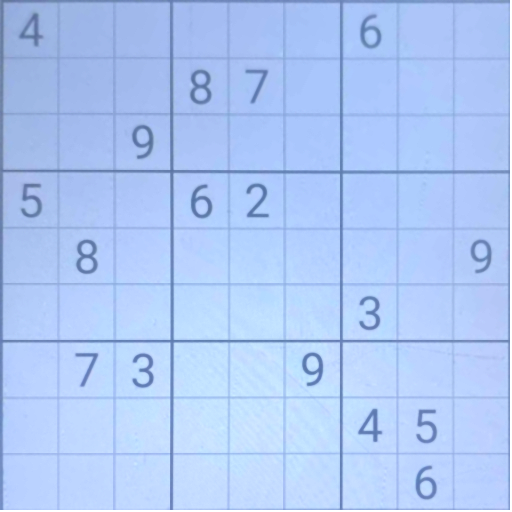

In [9]:
img_path = "/content/sudoku_01.jpg"
image_cv2 = cv2.imread(img_path)
image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
sudoku_board_rgb = find_puzzle(image_cv2, debug=False)
sudoku_board_rgb = preprocess_board(sudoku_board_rgb)
sudoku_board_rgb = process_sudoku_grid_rgb(sudoku_board_rgb)
display(Image.fromarray(cv2.resize(sudoku_board_rgb, (512, 512))))


---------------------------
9x9 (3x3) SUDOKU PUZZLE
Difficulty: 0.79
---------------------------
+-------+-------+-------+
| 4     |       | 6     |
|       | 8 7   |       |
|     9 |       |       |
+-------+-------+-------+
| 5     | 6 2   |       |
|   8   |       |     9 |
|       |       | 3     |
+-------+-------+-------+
|   7 3 |     9 |       |
|       |       | 4 5   |
|       |       |   6   |
+-------+-------+-------+

        
Found 17 text regions:
--------------------------------------------------


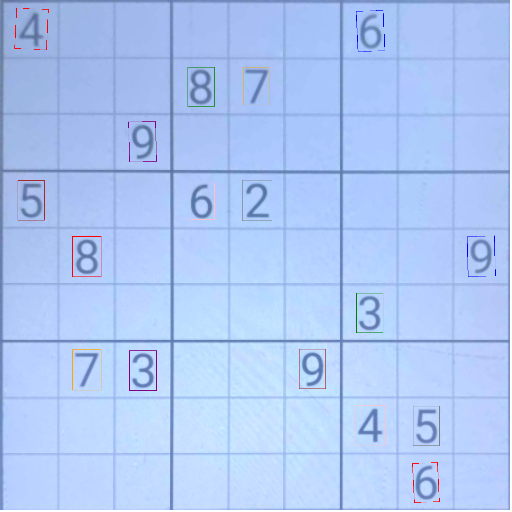

DETAILED OCR RESULTS
Total text regions detected: 17
Valid digit detections (score ≥ 0.5): 17
Average confidence score (valid only): 0.9973
Minimum confidence score (valid only): 0.9771
Maximum confidence score (valid only): 0.9998

OCR sudoku results:
------------------------------------------------------------
Score: 0.9985 | Text: '4'

Score: 0.9989 | Text: '6'

Score: 0.9989 | Text: '8'

Score: 0.9994 | Text: '7'

Score: 0.9986 | Text: '9'

Score: 0.9983 | Text: '5'

Score: 0.9974 | Text: '6'

Score: 0.9998 | Text: '2'

Score: 0.9986 | Text: '8'

Score: 0.9988 | Text: '9'

Score: 0.9988 | Text: '3'

Score: 0.9996 | Text: '7'

Score: 0.9985 | Text: '3'

Score: 0.9983 | Text: '9'

Score: 0.9983 | Text: '4'

Score: 0.9969 | Text: '5'

Score: 0.9771 | Text: '6'



In [10]:
# OCR sudoku board
sudoku_grid, confidence_scores, ocr_result = parse_sudoku_ocr(sudoku_board_rgb)
puzzle = create_sudoku_puzzle(sudoku_grid)
print(puzzle)

# Visualize the results
visualized_img = visualize_paddleocr_result(sudoku_board_rgb, ocr_result)

# Print detailed analysis
print_detailed_results(ocr_result)

In [11]:
solved_puzzle = solve_sudoku(puzzle)
print(solved_puzzle)


---------------------------
9x9 (3x3) SUDOKU PUZZLE
Difficulty: SOLVED
---------------------------
+-------+-------+-------+
| 4 2 8 | 3 9 1 | 6 7 5 |
| 1 3 5 | 8 7 6 | 2 9 4 |
| 7 6 9 | 2 5 4 | 8 3 1 |
+-------+-------+-------+
| 5 9 1 | 6 2 3 | 7 4 8 |
| 3 8 6 | 4 1 7 | 5 2 9 |
| 2 4 7 | 9 8 5 | 3 1 6 |
+-------+-------+-------+
| 6 7 3 | 5 4 9 | 1 8 2 |
| 9 1 2 | 7 6 8 | 4 5 3 |
| 8 5 4 | 1 3 2 | 9 6 7 |
+-------+-------+-------+

        


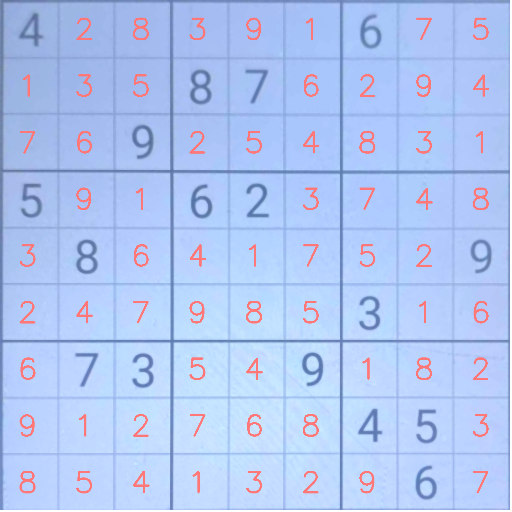

In [12]:
display(Image.fromarray(cv2.resize(draw_solution_on_board(sudoku_board_rgb, puzzle.board, solved_puzzle.board, ocr_result), (512, 512))))

In [13]:
def sudoku_solver(img_path):
    # Reading and preprocessing image
    image_cv2 = cv2.imread(img_path)
    image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
    sudoku_board_rgb = find_puzzle(image_cv2, debug=False)
    sudoku_board_rgb = preprocess_board(sudoku_board_rgb)
    sudoku_board_rgb = process_sudoku_grid_rgb(sudoku_board_rgb)

    # OCR sudoku board
    sudoku_grid, confidence_scores, ocr_result = parse_sudoku_ocr(sudoku_board_rgb)
    puzzle = create_sudoku_puzzle(sudoku_grid)
    print(puzzle)

    # Visualize the results
    visualized_img = visualize_paddleocr_result(sudoku_board_rgb, ocr_result)

    # Solve sudoku
    solved_puzzle = solve_sudoku(puzzle)
    print(solved_puzzle)

    return draw_solution_on_board(sudoku_board_rgb, puzzle.board, solved_puzzle.board, ocr_result)

# Sudoku board has user's note

In [14]:
import requests
from io import BytesIO

url = "https://datasets-server.huggingface.co/first-rows?dataset=Lexski%2Fsudoku-image-recognition&config=default&split=train"
response = requests.get(url)
data = response.json()

display(data['rows'][0]['row']['image']['src'])

'https://datasets-server.huggingface.co/assets/Lexski/sudoku-image-recognition/--/e9b8922f2463dc80abb39d23bb3deaa4c621b976/--/default/train/0/image/image.jpg?Expires=1749483662&Signature=il5BNSgUcKmBAkZU4gIXF5~x3Emkm5qN4cz1a9tcBFQU19NihKPrMJGPJ8CEaGFPO3EhA3l-H1pe0tB3j8AN8EIpAFrZNbtL2yeEc77zcshIC2tmCWr4ffHDg01Vl1nnm7gp0WcgSr7J2I287~3H41go5WY1Sb-dZFe~XPaQW1CkyhJuOEeNBvdqzDFYrbNnPV6-3KDHphxMoiHpg6rRNL-NHQuiV6We5ilWEiwSAkQ~4XQjwrKqc4UAhrcwJjetijWBNH9vn79dYPkzISeQgb8Uaw4O3LimQFfskgXGw5rBYt7kzL4U0w6yY-hNksyfbwY0xr8QicLVeSOw6sSHBA__&Key-Pair-Id=K3EI6M078Z3AC3'

In [14]:
def parse_sudoku_ocr_has_note(sudoku_board_rgb):
    # Get image dimensions
    height, width = sudoku_board_rgb.shape[:2]
    cell_height = height // 9
    cell_width = width // 9

    # Initialize 9x9 grid for digits and confidence scores
    sudoku_grid = [[0 for _ in range(9)] for _ in range(9)]
    confidence_scores = [[0.0 for _ in range(9)] for _ in range(9)]

    # Run OCR on the entire image
    results = ocr.predict(
        sudoku_board_rgb,
        use_doc_orientation_classify=True
    )

    if not results or not results[0]:
        return sudoku_grid, confidence_scores, {'rec_texts': [], 'rec_scores': [], 'rec_polys': []}

    # Extract OCR results
    rec_texts = results[0]['rec_texts']
    rec_scores = results[0]['rec_scores']
    rec_polys = results[0]['rec_polys']

    # Dictionary to track bounding boxes per cell
    cell_bboxes = [[[] for _ in range(9)] for _ in range(9)]

    # Assign bounding boxes to cells based on their center
    for text, score, poly in zip(rec_texts, rec_scores, rec_polys):
        # Skip invalid or low-confidence results
        if not text or score < 0.7 or not text.isdigit():
            continue

        # Get bounding box coordinates
        x_coords = poly[:, 0]
        y_coords = poly[:, 1]
        x_min, x_max = int(min(x_coords)), int(max(x_coords))
        y_min, y_max = int(min(y_coords)), int(max(y_coords))

        # Calculate the center of the bounding box
        x_center = (x_min + x_max) // 2
        y_center = (y_min + y_max) // 2

        # Determine the primary cell based on the center
        row = min(y_center // cell_height, 8)  # Ensure within 0-8
        col = min(x_center // cell_width, 8)   # Ensure within 0-8

        # Store bounding box info for this cell
        cell_bboxes[row][col].append({
            'text': text,
            'score': score,
            'poly': poly,
            'x_min': x_min,
            'x_max': x_max,
            'y_min': y_min,
            'y_max': y_max,
            'x_center': x_center,
            'y_center': y_center
        })

    # Process each cell
    for row in range(9):
        for col in range(9):
            bboxes = cell_bboxes[row][col]

            # Skip cells with 2 or more bounding boxes (likely notes)
            if len(bboxes) >= 2:
                continue

            # If cell has exactly one bounding box, apply additional checks
            if len(bboxes) == 1:
                bbox = bboxes[0]
                text = bbox['text']
                score = bbox['score']
                x_min, x_max = bbox['x_min'], bbox['x_max']
                y_min, y_max = bbox['y_min'], bbox['y_max']
                x_center, y_center = bbox['x_center'], bbox['y_center']

                # Calculate bounding box dimensions
                bbox_width = x_max - x_min
                bbox_height = y_max - y_min
                bbox_area = bbox_width * bbox_height

                # Calculate cell area
                cell_area = cell_width * cell_height

                # Skip if bounding box area is less than 30% of cell area
                if bbox_area < 0.13 * cell_area:
                    continue

                # Check if bounding box center is within the central region of the cell
                if bbox_area < cell_area:
                    padding_ratio = 0.3
                    x_min_cell = col * cell_width
                    x_max_cell = (col + 1) * cell_width
                    y_min_cell = row * cell_height
                    y_max_cell = (row + 1) * cell_height

                    x_center_min = x_min_cell + padding_ratio * cell_width
                    x_center_max = x_max_cell - padding_ratio * cell_width
                    y_center_min = y_min_cell + padding_ratio * cell_height
                    y_center_max = y_max_cell - padding_ratio * cell_height

                    if not (x_center_min <= x_center <= x_center_max and y_center_min <= y_center <= y_center_max):
                        continue

                # Handle single-digit case
                if len(text) == 1 and 1 <= int(text) <= 9:
                    sudoku_grid[row][col] = int(text)
                    confidence_scores[row][col] = score

                # Handle multi-digit case (e.g., "62" or "347")
                elif len(text) > 1:
                    # Calculate which cells the bounding box spans
                    start_col = max(x_min // cell_width, 0)
                    end_col = min((x_max + cell_width - 1) // cell_width, 9)
                    start_row = max(y_min // cell_height, 0)
                    end_row = min((y_max + cell_height - 1) // cell_height, 9)

                    # Split digits across cells (assume horizontal span for now)
                    num_cells = end_col - start_col
                    if num_cells == len(text) and num_cells > 1:
                        # Horizontal span: assign digits left-to-right
                        for i, digit in enumerate(text):
                            if 1 <= int(digit) <= 9:
                                col_idx = start_col + i
                                if col_idx < 9 and row < 9:
                                    sudoku_grid[row][col_idx] = int(digit)
                                    confidence_scores[row][col_idx] = score
                    elif end_row - start_row == len(text) and len(text) > 1:
                        # Vertical span: assign digits top-to-bottom
                        for i, digit in enumerate(text):
                            if 1 <= int(digit) <= 9:
                                row_idx = start_row + i
                                if row_idx < 9 and col < 9:
                                    sudoku_grid[row_idx][col] = int(digit)
                                    confidence_scores[row_idx][col] = score

    return sudoku_grid, confidence_scores, results[0]

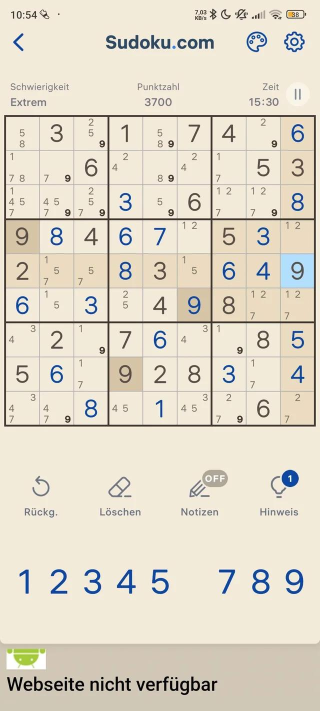

In [12]:
def get_sudoku_image(idx):
    url = "https://datasets-server.huggingface.co/first-rows?dataset=Lexski%2Fsudoku-image-recognition&config=default&split=train"
    response = requests.get(url)
    data = response.json()

    image_response = requests.get(data['rows'][idx]['row']['image']['src'])
    img_array = np.asarray(bytearray(image_response.content), dtype=np.uint8)
    img_bgr = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb

img_rgb = get_sudoku_image(21)
display(Image.fromarray(cv2.resize(img_rgb, (0, 0), fx=0.5, fy=0.5)))

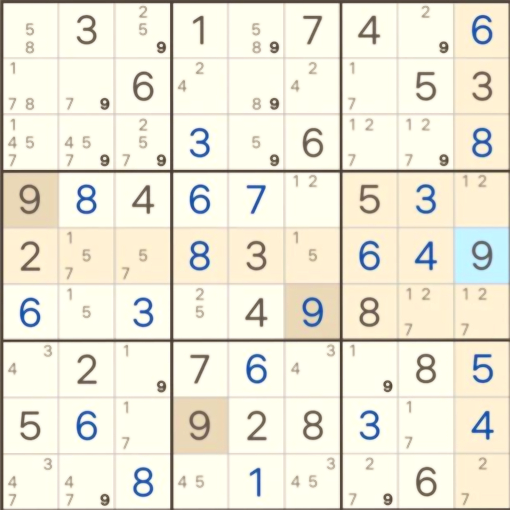


---------------------------
9x9 (3x3) SUDOKU PUZZLE
Difficulty: 0.46
---------------------------
+-------+-------+-------+
|   3   | 1   7 | 4   6 |
|     6 |       |   5 3 |
|       | 3   6 |     8 |
+-------+-------+-------+
| 9 8 4 | 6 7   | 5 3   |
| 2     | 8 3   | 6 4 9 |
| 6   3 |   4 9 | 8     |
+-------+-------+-------+
|   2   | 7 6   |   8 5 |
| 5 6   | 9 2 8 | 3   4 |
|     8 |   1   |   6   |
+-------+-------+-------+

        
Found 129 text regions:
--------------------------------------------------


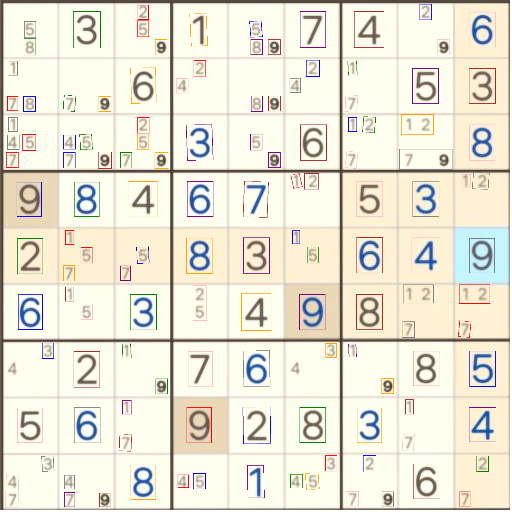


---------------------------
9x9 (3x3) SUDOKU PUZZLE
Difficulty: SOLVED
---------------------------
+-------+-------+-------+
| 8 3 2 | 1 5 7 | 4 9 6 |
| 1 9 6 | 2 8 4 | 7 5 3 |
| 7 4 5 | 3 9 6 | 2 1 8 |
+-------+-------+-------+
| 9 8 4 | 6 7 2 | 5 3 1 |
| 2 5 7 | 8 3 1 | 6 4 9 |
| 6 1 3 | 5 4 9 | 8 2 7 |
+-------+-------+-------+
| 4 2 9 | 7 6 3 | 1 8 5 |
| 5 6 1 | 9 2 8 | 3 7 4 |
| 3 7 8 | 4 1 5 | 9 6 2 |
+-------+-------+-------+

        


In [15]:
def sudoku_solver_with_note(img):
    sudoku_board_rgb = find_puzzle(img, debug=False)
    sudoku_board_rgb = preprocess_board(sudoku_board_rgb)
    sudoku_board_rgb = process_sudoku_grid_rgb(sudoku_board_rgb)
    display(Image.fromarray(cv2.resize(sudoku_board_rgb, (512, 512))))

    sudoku_grid, confidence_scores, ocr_result = parse_sudoku_ocr_has_note(sudoku_board_rgb)
    puzzle = create_sudoku_puzzle(sudoku_grid)
    print(puzzle)

    visualized_img = visualize_paddleocr_result(sudoku_board_rgb, ocr_result)

    solved_puzzle = solve_sudoku(puzzle)
    print(solved_puzzle)

    return draw_solution_on_board(sudoku_board_rgb, puzzle.board, solved_puzzle.board, ocr_result)


solved_puzzle_img = sudoku_solver_with_note(img_rgb)